In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from craterdetection.deepmoon import DeepMoon, template_match_t
import cartopy.crs as ccrs
import cartopy.img_transform as cimg
import matplotlib.pyplot as plt
import sklearn.neighbors

In [4]:
R = 1737.4 #km

moon = ccrs.Globe(
    semimajor_axis=R*1000,
    semiminor_axis=R*1000,
    ellipse=None
)

geodetic = ccrs.Geodetic(globe=moon)
plate_proj = ccrs.PlateCarree(globe=moon)
ortho_proj = ccrs.Orthographic(globe=moon)
near_proj = ccrs.NearsidePerspective(satellite_height = 5000e3, globe=moon)

In [5]:
import pandas as pd
import numpy as np

df_craters  = pd.read_csv("../data/lunar_crater_database_robbins_2018.csv")
df_craters.query('DIAM_CIRC_IMG > 20', inplace=True)

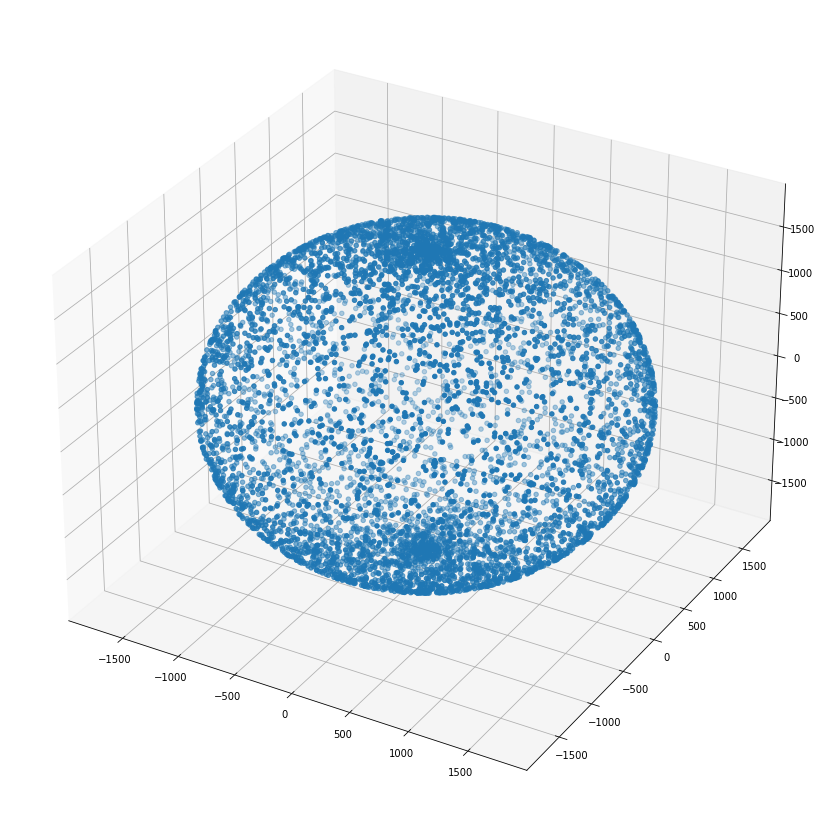

In [59]:
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, 'o')

In [103]:
A = sklearn.neighbors.kneighbors_graph(np.array([x, y, z]).T, 20, mode='distance', metric='euclidean', n_jobs=-1)
sparsity = 1 - A.count_nonzero() / np.multiply(*A.shape)
print(f'{repr(A)}\nSparsity: {sparsity}')

<6973x6973 sparse matrix of type '<class 'numpy.float64'>'
	with 139460 stored elements in Compressed Sparse Row format>
Sparsity: 0.9971317940628137


In [111]:
A > 100

<6973x6973 sparse matrix of type '<class 'numpy.bool_'>'
	with 84207 stored elements in Compressed Sparse Row format>

In [10]:
import networkx as nx

G = nx.from_scipy_sparse_matrix(A, parallel_edges=False, create_using=None, edge_attribute='weight')

In [88]:
subG = nx.ego_graph(G, 2, 3)
subG.number_of_nodes()

59

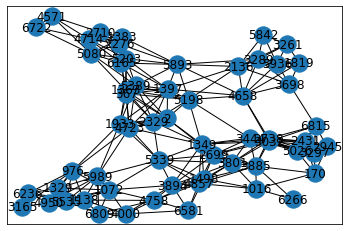

In [89]:
nx.draw_networkx(subG)

In [90]:
GM = nx.algorithms.isomorphism.GraphMatcher(G, subG)

In [91]:
%%time
GM.subgraph_is_isomorphic()

KeyboardInterrupt: 

KeyboardInterrupt: 

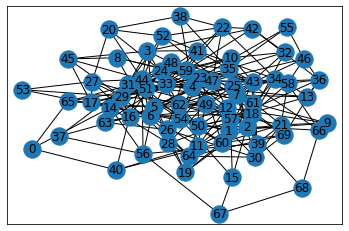

In [81]:
randomG = nx.gnp_random_graph(70, 0.1)
nx.draw_networkx(randomG)
GM2 = nx.algorithms.isomorphism.GraphMatcher(G, randomG)
GM2.subgraph_is_isomorphic()

In [35]:
G[1, 2]

KeyError: (1, 2)

In [8]:
from scipy.spatial.distance import cdist
xyz = np.array([x, y, z]).T
theta_ij = np.arccos(1-cdist(xyz, xyz, 'cosine'))/np.pi

theta_ij.shape

(6973, 6973)

In [9]:
import numpy.linalg as LA
import numpy as np

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the Moon (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 1737.1 * c
    return km

In [33]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Image metadata
img = cv2.imread('../data/scr00022.jpg', cv2.IMREAD_GRAYSCALE)
latitude = "1-0-0.0N"
longitude = "175-0-0.0E"

##assuming N latitude and W longitude
latitude = sum(float(x) / 60 ** n for n, x in enumerate(latitude[:-1].split('-')))  * (1 if 'N' in latitude[-1] else -1)
longitude = sum(float(x) / 60 ** n for n, x in enumerate(longitude[:-1].split('-'))) * (1 if 'E' in longitude[-1] else -1)
longitude = (360 + longitude) if longitude < 0 else longitude

h = 211 #km
fov = 45 #degrees (vertical FOV uncropped image)

# Crop center of screenshot to input shape 
ysize, xsize = img.shape
x_in, y_in = (1080, 1080)
img = img[(ysize//2)-(y_in//2):(ysize//2)+(y_in//2), (xsize//2)-(x_in//2):(xsize//2)+(x_in//2)]

# Image dimension
d = 2*(y_in/ysize)*h*np.tan(np.deg2rad(fov/2)) 
fov_crop = np.rad2deg(np.arctan(d/h))
R = 1737.4
circ = 2*np.pi*R
d_angle = (d/circ)*360
lat_min, lat_max = (latitude - (d_angle/2), latitude + (d_angle/2))
long_min, long_max = (longitude - (d_angle/2), longitude + (d_angle/2))
((long_min, long_max), (lat_min, lat_max))

((172.11776368909688, 177.88223631090312),
 (-1.8822363109031164, 3.8822363109031164))

In [170]:
df_close = df_craters.query("(LON_ELLI_IMG < @long_max) & (LON_ELLI_IMG > @long_min)")
df_close = df_close.query("(LAT_ELLI_IMG < @lat_max) & (LAT_ELLI_IMG > @lat_min)")
df_close

,CRATER_ID,LAT_ELLI_IMG,LON_ELLI_IMG,DIAM_CIRC_IMG
834538,08-1-002301,1.047510,173.698,10.96370
834539,08-1-002302,1.813410,173.491,8.66433
834540,08-1-002303,1.875370,173.217,17.71590
834543,08-1-002306,3.574150,173.206,18.82340
834544,08-1-002307,3.625820,172.706,10.11030
...,...,...,...,...
1175994,09-3-000283,-0.360151,175.895,1.32799
1175995,09-3-000286,-0.418822,176.081,1.61292
1175996,09-3-000291,-0.302092,175.645,2.76087
1175997,09-3-000293,-0.248940,175.231,1.13672


In [171]:
df_close.eval('long_pix = ((LON_ELLI_IMG - @long_min) / @d_angle) * @x_in', inplace=True)
df_close.eval('lat_pix = ((LAT_ELLI_IMG - @lat_min) / @d_angle) * @y_in', inplace=True)
df_close

,CRATER_ID,LAT_ELLI_IMG,LON_ELLI_IMG,DIAM_CIRC_IMG,long_pix,lat_pix
834538,08-1-002301,1.047510,173.698,10.96370,296.064415,548.901213
834539,08-1-002302,1.813410,173.491,8.66433,257.282030,692.396040
834540,08-1-002303,1.875370,173.217,17.71590,205.946891,704.004526
834543,08-1-002306,3.574150,173.206,18.82340,203.885991,1022.278637
834544,08-1-002307,3.625820,172.706,10.11030,110.208732,1031.959245
...,...,...,...,...,...,...
1175994,09-3-000283,-0.360151,175.895,1.32799,707.682295,285.169563
1175995,09-3-000286,-0.418822,176.081,1.61292,742.530236,274.177285
1175996,09-3-000291,-0.302092,175.645,2.76087,660.843665,296.047179
1175997,09-3-000293,-0.248940,175.231,1.13672,583.278894,306.005446


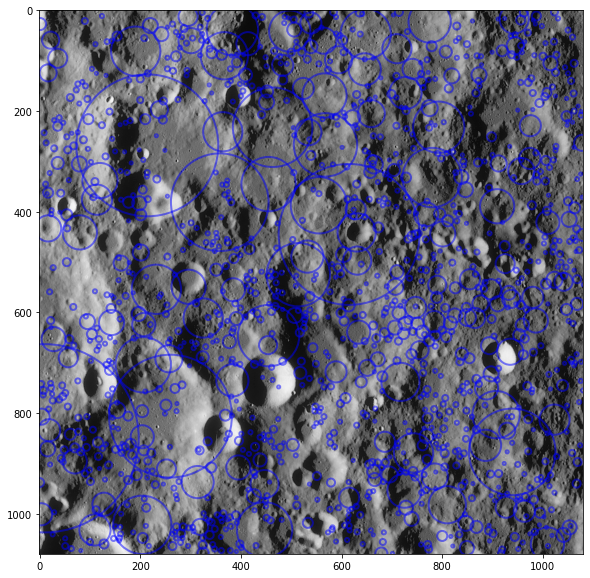

In [172]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
axes.imshow(img, cmap='Greys_r')

for r in df_close.iterrows():
    row = r[1]
    x, y = (round(row['long_pix']), round(row['lat_pix']))
    radius = round(((row['DIAM_CIRC_IMG']/d)/2)*x_in)
    circle = plt.Circle((x, y), radius, color='blue', fill=False, linewidth=2, alpha=0.5)
    axes.add_artist(circle)

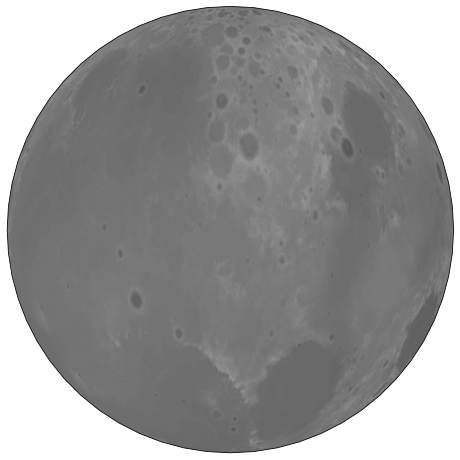

In [60]:
import os
import matplotlib.pyplot as plt

from cartopy import config
import cartopy.crs as ccrs


fig = plt.figure(figsize=(8, 12))

# get the path of the file. It can be found in the repo data directory.
fname = '../data/LRO_LrocKaguya_DEMmerge_60N60S_full.jpg'
img_extent = (-180.0, 180.0, -60.0, 60.0)
img = plt.imread(fname)

ax = plt.axes(projection=near_proj)

# set a margin around the data
ax.set_xmargin(0.05)
ax.set_ymargin(0.10)

ax.imshow(img, origin='lower', transform=plate_proj)

In [52]:
ax.get_geometry()

(1, 1, 1)

In [47]:
moon.semimajor_axis

1737400.0